In [1]:
###### load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# import paired ttest
from scipy.stats import ttest_rel
from scipy.stats import wilcoxon

# needed for editable text in svg format
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['text.usetex'] = False
plt.rcParams['svg.fonttype'] = 'none'

# import homemade functions:
from MAPseq_processing import *
from MAPseq_plotting import *

# import metadata
from M194_M220_metadata import *

# import colormaps
from colormaps import blue_cmp, orange_cmp

%matplotlib inline

# auto refreshes imported functions if source code changes:
%load_ext autoreload
%autoreload 2


# simulation 2 areas
- you have two areas A, B
- where P(A) = 0.9, P(B) = 0.1
- areas are indpendent
- Let's say we have 1000 neurons

In [196]:
true_ntot = 1000
trials = 500
# pa = 0.9
# pb = 0.1

pa_series = [0.6, 0.7, 0.8, 0.9] # didn't work w/ pa=0.5

pb_series = [0.01, 0.1, 0.15, 0.5, 0.9]

stds = []

results = pd.DataFrame(columns=["p(A)", "p(B)", "n_tot_mu", "n_tot_sigma", "trials"])

i=0
for pa in pa_series:
    for pb in pb_series:

        n_tots = []
        for rs in range(trials):
                
            a = [1]*int(pa*true_ntot) + [0]*int((1-pa)*true_ntot)
            b = [1]*int(pb*true_ntot) + [0]*int((1-pb)*true_ntot)
            a_shuffle = pd.Series(a).sample(frac=1, ignore_index=True, random_state=rs)
            b_shuffle = pd.Series(b).sample(frac=1, ignore_index=True, random_state=rs+500)
            test = pd.DataFrame({"A":a_shuffle, "B":b_shuffle})
            n0_idx = test.sum(axis=1)>0
            test_n0 = test[n0_idx].reset_index(drop=True)

            # estimate n_total
            ntot = estimate_n_total(test_n0, plot_areas=["A", "B"])
            n_tots.append(ntot)

        mu = np.mean(n_tots)
        sigma = np.std(n_tots)

        results.loc[i] = [pa, pb, mu, sigma, trials]

        i+=1

results


,p(A),p(B),n_tot_mu,n_tot_sigma,trials
0,0.6,0.01,1094.620,414.332470,500.0
1,0.6,0.10,1005.748,78.867512,500.0
2,0.6,0.15,1001.238,63.183015,500.0
3,0.6,0.50,999.014,25.794065,500.0
4,0.6,0.90,999.378,8.329893,500.0
5,0.7,0.01,1071.938,313.156239,500.0
6,0.7,0.10,1003.364,64.081319,500.0
7,0.7,0.15,1002.082,50.852643,500.0
8,0.7,0.50,999.152,20.615841,500.0
9,0.7,0.90,999.668,6.851407,500.0


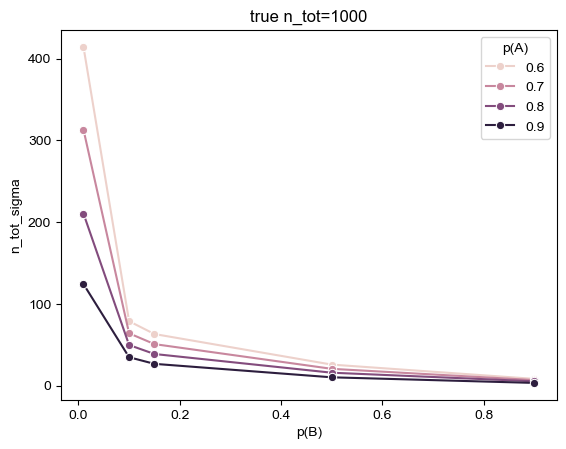

In [205]:
sns.lineplot(results, x="p(B)", y="n_tot_sigma", hue="p(A)", marker="o")
plt.title("true n_tot=1000")
plt.show()

# Simulate with probabilities from data

In [206]:
# set-up variables
in_path = '/Volumes/Data/Emily/MAPseq/combined_analysis_M194_M220/processed_data/'
# out_path = '/Volumes/Data/Emily/figures/fig_3_sc/python_out/'
# out_path = '/Volumes/Data/Emily/figures/fig_2_mapseq/figure_pics/'
out_path = "/Users/eisko/Documents/CSHL/mapseq_paper/svg_images/"

#### load data - OMC
omc_bin = pd.read_pickle(in_path+"M194_M220_OMC_bin4.pkl")
# omc_countN = pd.read_pickle(in_path+"M194_M220_OMC_countN4.pkl")

# Preprocessing/sorting
## initial processing - OMC


# bin processing
omc_clean = [clean_up_data(df) for df in omc_bin]
omc_type = [sort_by_celltype(df) for df in omc_clean]

# seperate it cells
omc_it = [df[df['type']=="IT"] for df in omc_type]



In [211]:
plot_areas = ["OMCc", "AUD", "STR"]

# Estimate n-totals
n_totals = [estimate_n_total(omc_it[i], plot_areas) for i in range(len(omc_it))]

# Count obs motifs
n_obs_motifs = [df_to_motif_proportion(df, areas=plot_areas, proportion=False) for df in omc_it]
motifs = n_obs_motifs[0].index

# convert to proportions using adjusted n_totals
p_obs_motifs = [n_obs_motifs[i]/n_totals[i] for i in range(len(n_totals))]

# calculate proportions based on independent bulk probabilities adjusted for n_total
p_calc_motifs = [df_to_calc_pab_proportions(df, motifs, adjust_total=True) for df in omc_it]

motif_strings = TF_to_motifs(motifs)

# put into dataframe - note p_obs is adjusted for n_total
it_motifs_df = []
for i in range(len(n_totals)):
    df = pd.DataFrame({"motifs":motif_strings, "n_shape":omc_it[i].shape[0], "n_total":n_totals[i],
                  "n_obs":n_obs_motifs[i], "p_obs":p_obs_motifs[i], "p_calc":p_calc_motifs[i],
                  "mice":metadata.loc[i,"mice"], "species":metadata.loc[i,"species"]})
    it_motifs_df.append(df)
it_motifs_df = pd.concat(it_motifs_df).reset_index(drop=True)

it_motifs_df

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species
0,OMCc_,8287,8949,1123,0.125489,0.124100,MMM1,MMus
1,AUD_,8287,8949,3,0.000335,0.000980,MMM1,MMus
2,STR_,8287,8949,2668,0.298134,0.294598,MMM1,MMus
3,AUD_OMCc_,8287,8949,8,0.000894,0.001644,MMM1,MMus
4,OMCc_STR_,8287,8949,4379,0.489328,0.494259,MMM1,MMus
...,...,...,...,...,...,...,...,...
79,STR_,527,530,29,0.054717,0.053811,STM7,STeg
80,AUD_OMCc_,527,530,9,0.016981,0.018997,STM7,STeg
81,OMCc_STR_,527,530,351,0.662264,0.659190,STM7,STeg
82,AUD_STR_,527,530,4,0.007547,0.014256,STM7,STeg


In [217]:
p_aud = [omc_it[i]["AUD"].sum()/n_totals[i] for i in range(len(omc_it))]
p_omcc = [omc_it[i]["OMCc"].sum()/n_totals[i] for i in range(len(omc_it))]
p_str = [omc_it[i]["STR"].sum()/n_totals[i] for i in range(len(omc_it))]

pd.DataFrame({"AUD":p_aud, "OMCc":p_omcc, "STR":p_str}, index=metadata["mice"])

,AUD,OMCc,STR
mice,,,
MMM1,0.013074,0.626550,0.799307
MMF2,0.055824,0.652777,0.824439
MMF3,0.029781,0.757192,0.881212
STM1,0.111712,0.751351,0.834234
STM2,0.135593,0.661017,0.790254
STF3,0.084592,0.712991,0.712991
MMM4,0.135161,0.851704,0.923092
MMF5,0.009447,0.888722,0.945208
STF4,0.113019,0.796853,0.811159


In [218]:
round(0.333333*1000)

333

In [260]:
def given_prop_sim_data(area_probs, total_neurons=1000, start_random_state=10):
    """Given probabilties of areas, generate simulated data based on total number of neurons for given trials.

    Args:
        area_probs (dict): Dictionary in form {"area": area_prob}
        total_neurons (int): True total neuron number to create simulation. Defaults to 1000.
        random_state (int, optional): Initial random state to start shuffling. Defaults to 10.
        # trials (int, optional): Number of times to run simulation. Defaults to 500.
    """

    areas = list(area_probs.keys())

    # 1. given proportions, generate simulated data
    vectors = {}
    for i in range(len(areas)):
        area = areas[i]
        n_obs = round(area_probs[area] * total_neurons)
        area_sim = [1]*n_obs + [0]*(total_neurons-n_obs)
        area_shuffle = pd.Series(area_sim).sample(frac=1, ignore_index=True, random_state=start_random_state+i)
        vectors[area] = area_shuffle

    simulation = pd.DataFrame(vectors)

    # drop empty rows
    n0_idx = simulation.sum(axis=1)>0
    simulation_n0 = simulation[n0_idx].reset_index(drop=True)
    
    return(simulation_n0)



In [262]:
test = {"STR":0.8, "OMCc":0.7, "AUD":0.1}
trials = 500
sim_500 = [given_prop_sim_data(test, start_random_state=i*5) for i in range(trials)]

# calculate p_obs and p_est for every simulated trial


# Shuffling with paded dataset

In [270]:
shuf, sh_prop = motif_simulation(omc_it[0], adjust_total=True)

In [282]:
print(motif_strings)

# iterate through mice
mouse = metadata.loc[0, "mice"]
mouse_obs = it_motifs_df[it_motifs_df["mice"]==mouse]
row = mouse_obs[mouse_obs["motifs"]=="OMCc_"]
row["p_obs"]

['OMCc_', 'AUD_', 'STR_', 'AUD_OMCc_', 'OMCc_STR_', 'AUD_STR_', 'AUD_OMCc_STR_']


0    0.125489
Name: p_obs, dtype: float64

/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_3551/3491714709.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  motif_prop_sim = [sh_prop[rep][i] for rep in range(len(sh_prop))]


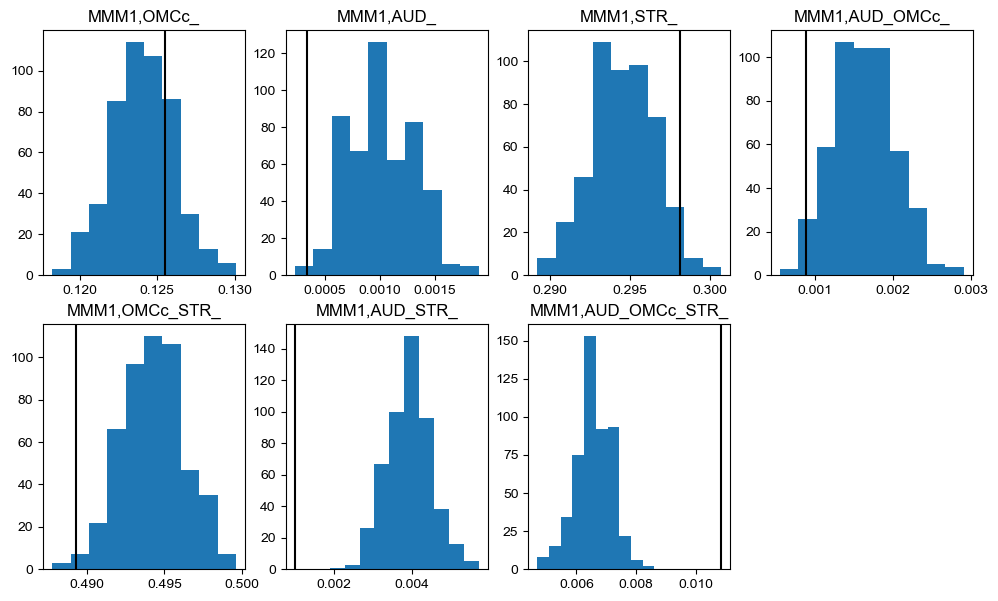

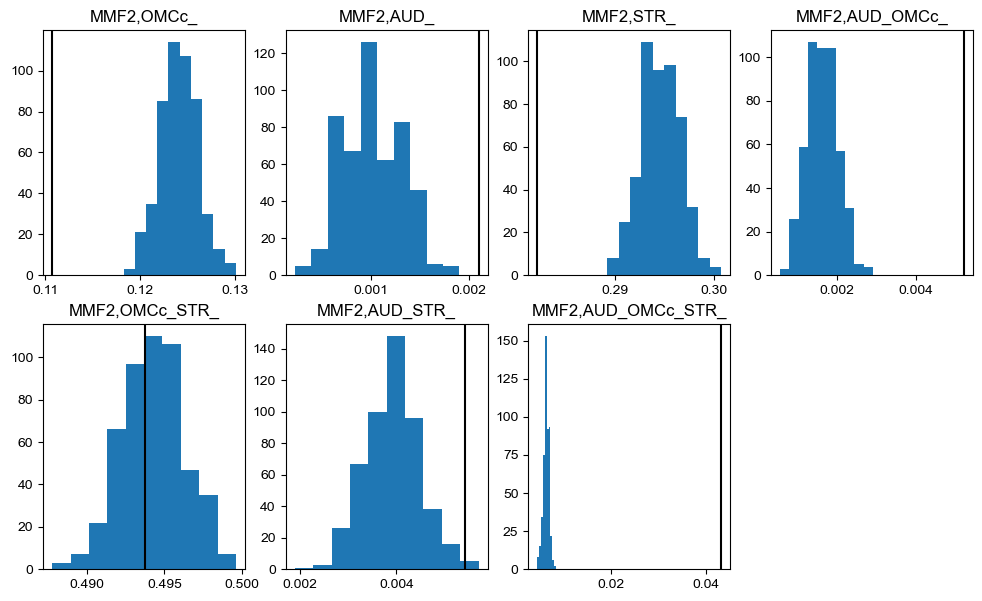

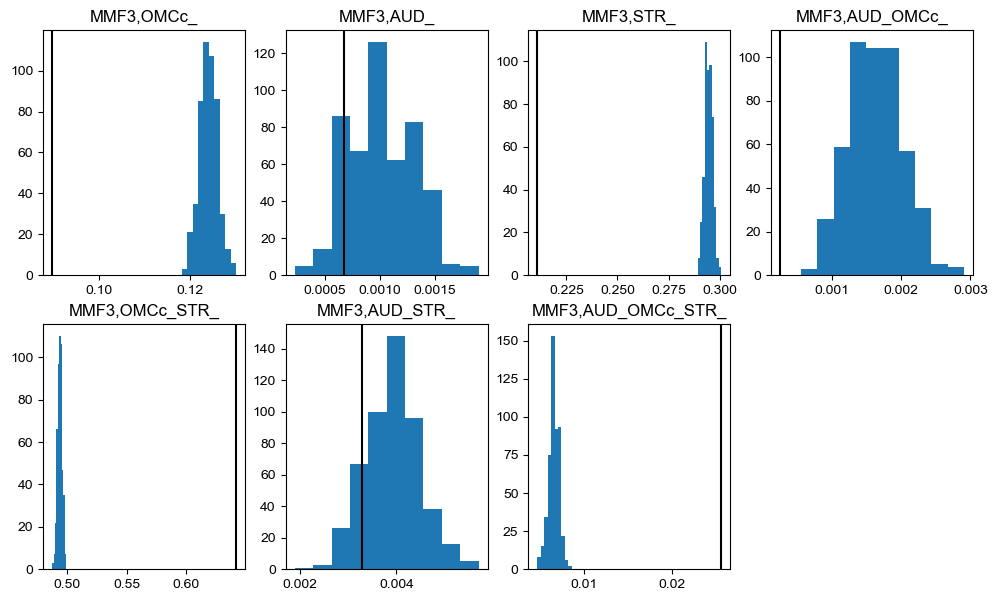

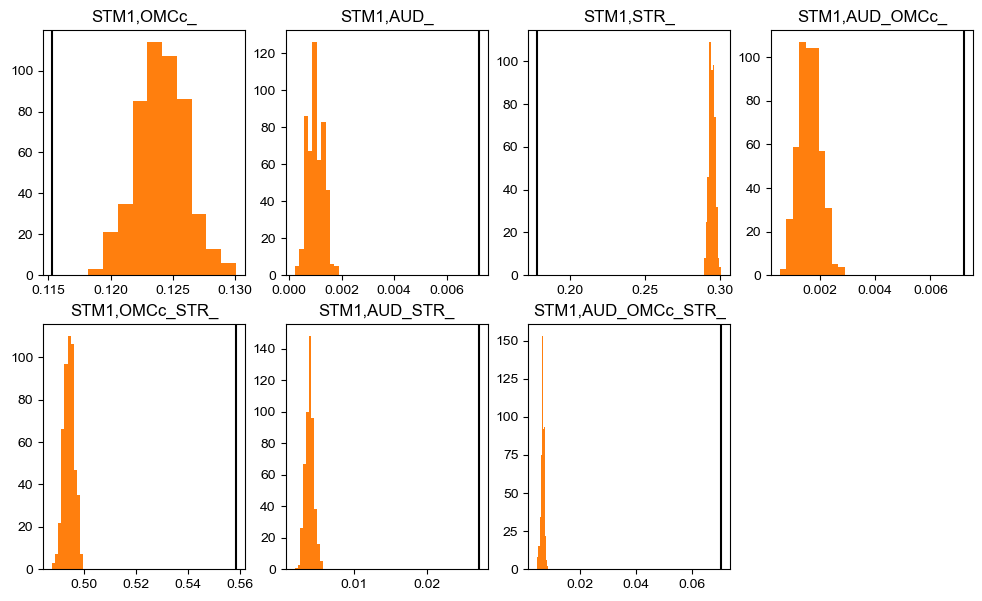

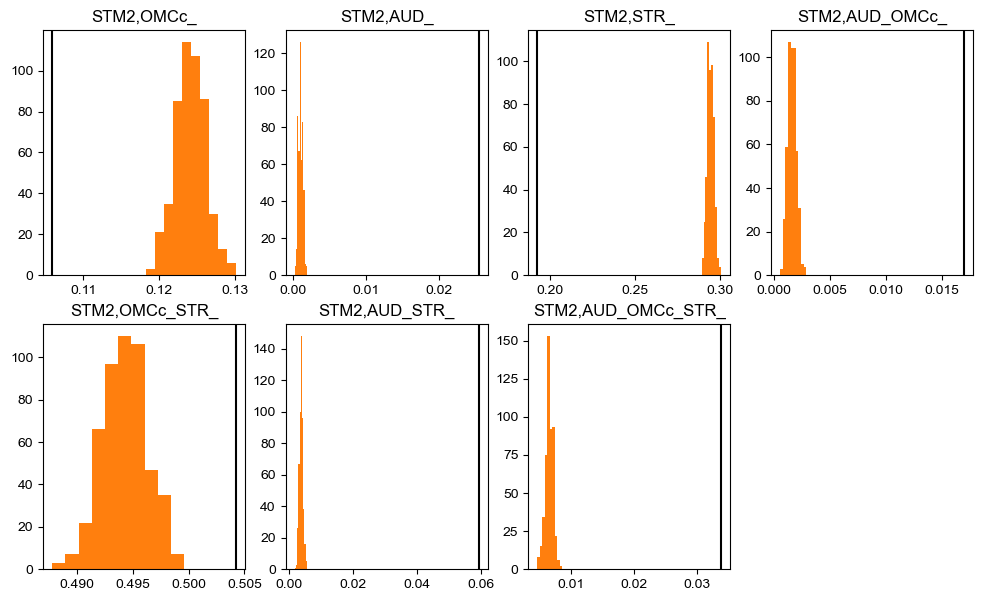

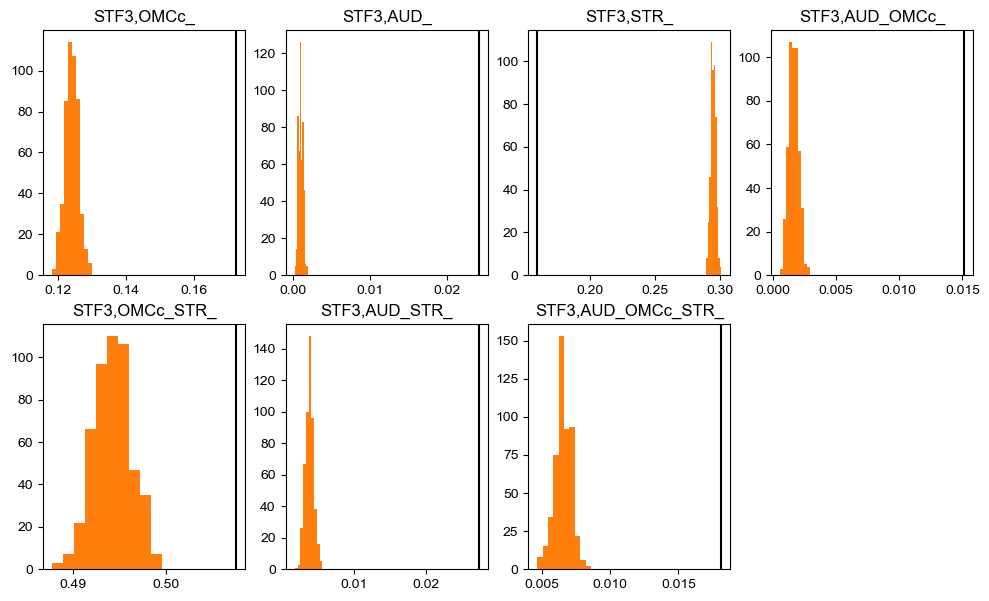

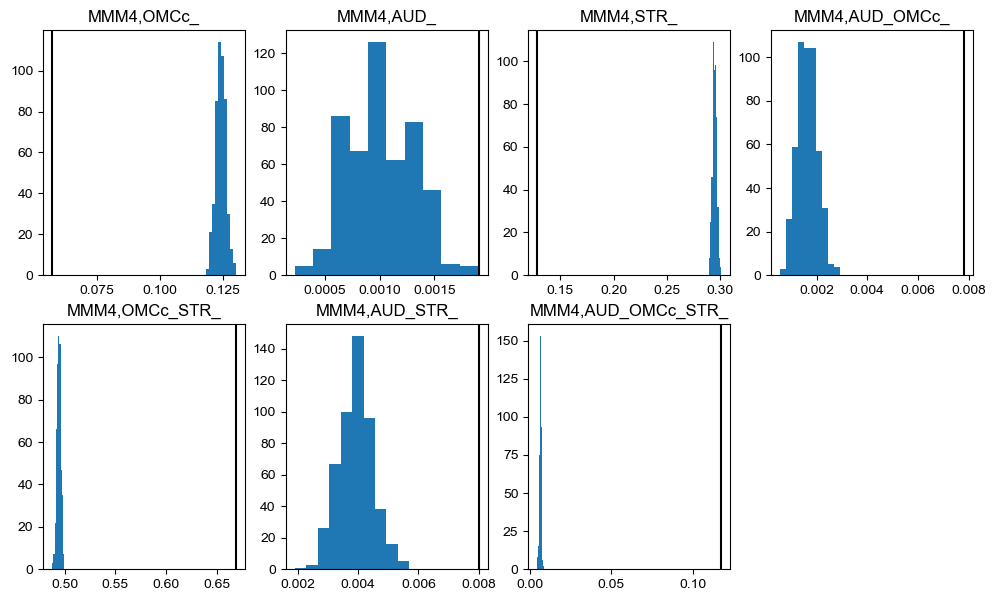

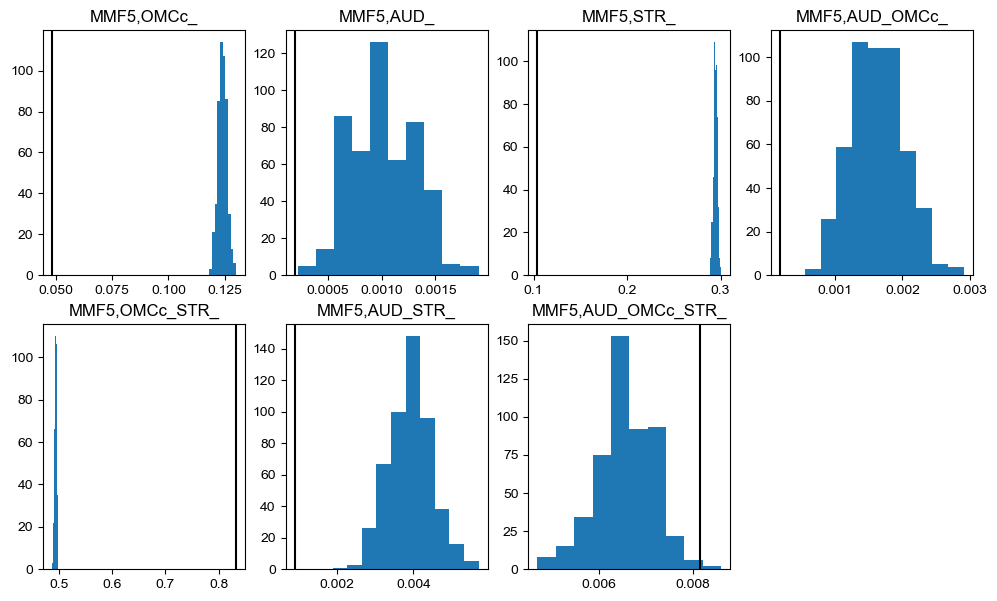

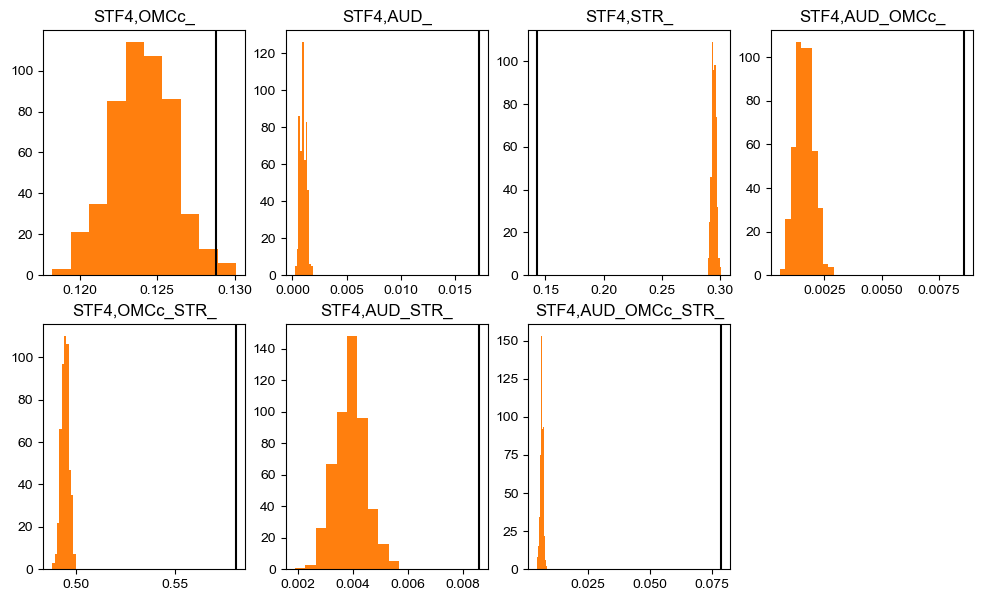

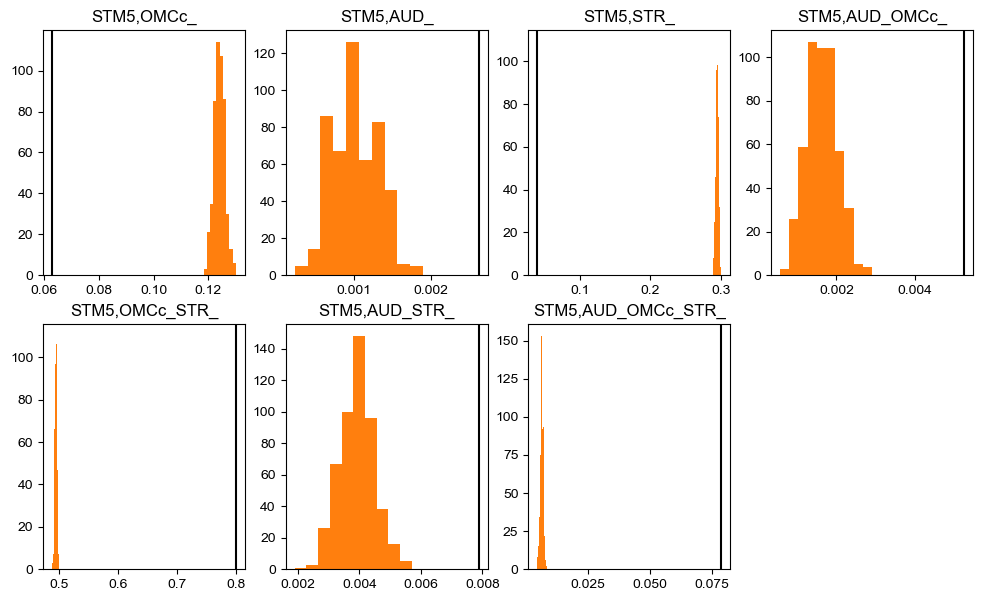

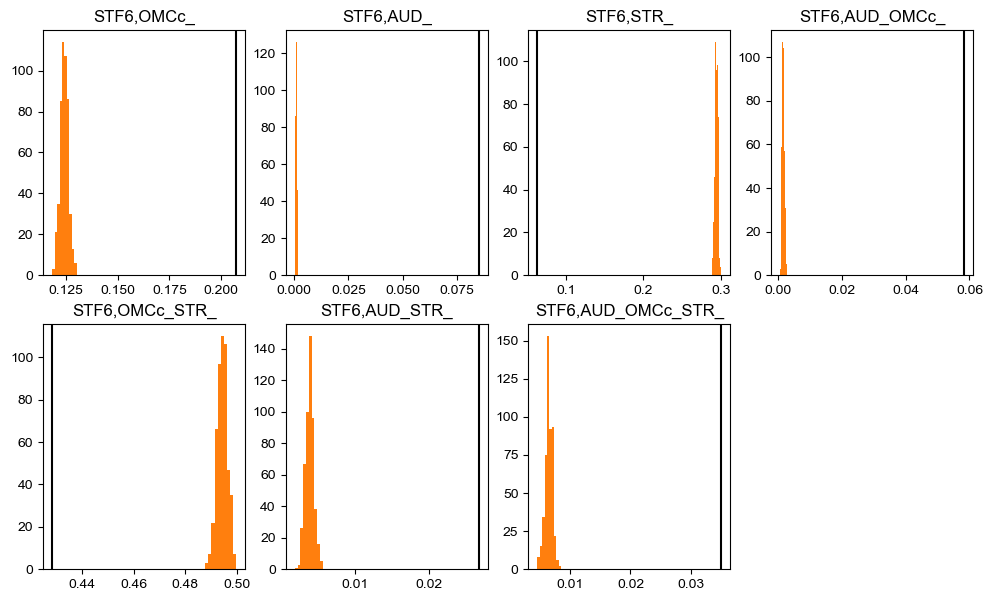

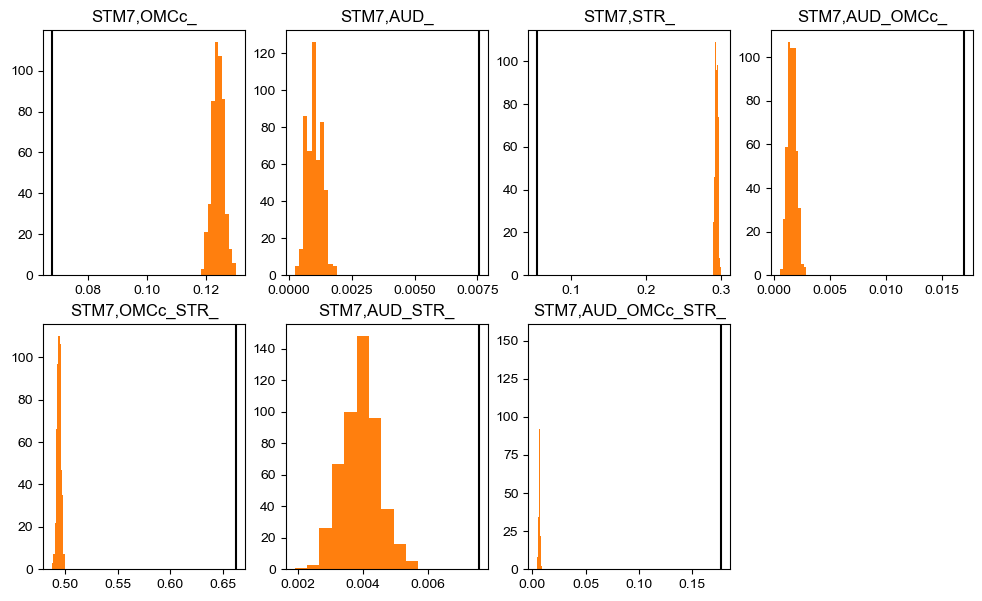

In [318]:
# iterate through mice

for m in range(metadata.shape[0]):
    mouse = metadata.loc[m, "mice"]
    mouse_obs = it_motifs_df[it_motifs_df["mice"]==mouse]

    if metadata.loc[m,"species"]=="STeg":
        color="tab:orange"
    else:
        color="tab:blue"
    fig, axs = plt.subplots(2,4, figsize=(12,7))

    # iterate through motifs
    i = 0
    for ax in axs.flat:
        if i>=7:
            ax.axis("off")
        else:
            motif = motif_strings[i]
            motif_prop_sim = [sh_prop[rep][i] for rep in range(len(sh_prop))]
                
            row = mouse_obs[mouse_obs["motifs"]==motif]
            p_obs = row["p_obs"].values[0]


            ax.hist(motif_prop_sim, color=color)
            ax.axline((p_obs, 0), (p_obs, 1), color="black")
            ax.set_title(mouse+","+motif)

        i+=1

    plt.savefig(out_path+mouse+"_n_tot_sim_hist.png", dpi=300, bbox_inches="tight")
    plt.show()



<class 'numpy.float64'>


/var/folders/l2/gvq0gkm95b1fbrlls4tsq2wr0000gp/T/ipykernel_3551/3472177000.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  motif_prop_sim = [sh_prop[rep][i] for rep in range(len(sh_prop))]


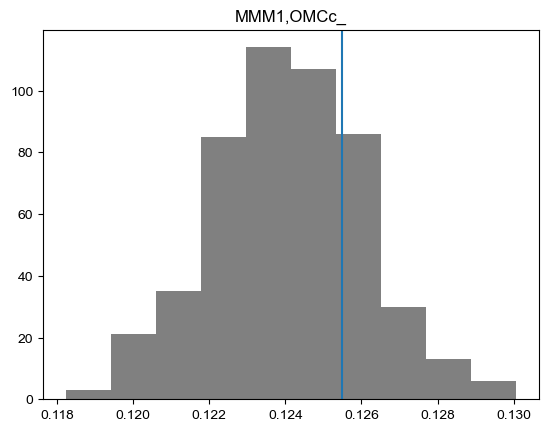

In [305]:


# plt.hist(motif_prop_sim, color="grey")
# plt.axline((p_obs,0), (0.12,1))

# plt.show()

In [279]:
it_motifs_df

,motifs,n_shape,n_total,n_obs,p_obs,p_calc,mice,species
0,OMCc_,8287,8949,1123,0.125489,0.124100,MMM1,MMus
1,AUD_,8287,8949,3,0.000335,0.000980,MMM1,MMus
2,STR_,8287,8949,2668,0.298134,0.294598,MMM1,MMus
3,AUD_OMCc_,8287,8949,8,0.000894,0.001644,MMM1,MMus
4,OMCc_STR_,8287,8949,4379,0.489328,0.494259,MMM1,MMus
...,...,...,...,...,...,...,...,...
79,STR_,527,530,29,0.054717,0.053811,STM7,STeg
80,AUD_OMCc_,527,530,9,0.016981,0.018997,STM7,STeg
81,OMCc_STR_,527,530,351,0.662264,0.659190,STM7,STeg
82,AUD_STR_,527,530,4,0.007547,0.014256,STM7,STeg
